# Background Detection Model (Transformer/MobileNetV3)
**Project**: Manya Part BG
**Architecture**: MobileNetV3 Small (Frozen Backbone)
**Task**: Binary Classification (REAL vs FAKE)
**Configuration**: Matches the successful Lavanya (Face) model setup.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Configuration
DATA_DIR = r'C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\dataset_split'
MODEL_SAVE_PATH = r'C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\bg_transformer.keras'

IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-3

CLASS_NAMES = ["fake", "real"]   # FAKE=0, REAL=1
AUTOTUNE = tf.data.AUTOTUNE

print("TensorFlow:", tf.__version__)

TensorFlow: 2.20.0


## 1. Data Loading

In [2]:
print(f"Loading data from {DATA_DIR}...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    class_names=CLASS_NAMES,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    class_names=CLASS_NAMES,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    class_names=CLASS_NAMES,
    shuffle=False
)

# --- Calculate Class Weights ---
y_train = []
for _, labels in train_ds:
    y_train.extend(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

# Data Augmentation
augmenter = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Preprocessing
def preprocess(images, labels):
    return preprocess_input(images), labels

def augment(images, labels):
    return augmenter(images), labels

# Apply to datasets
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

# Prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Loading data from C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\dataset_split...
Found 14016 files belonging to 2 classes.
Found 3003 files belonging to 2 classes.
Found 3005 files belonging to 2 classes.
Class Weights: {0: np.float64(0.9988597491448119), 1: np.float64(1.0011428571428571)}


## 2. Model Architecture (Frozen Backbone)

In [3]:
# Load Pretrained MobileNetV3Small
base_model = MobileNetV3Small(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# FREEZE the backbone
base_model.trainable = False 

# Create new model on top
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)  # Strong Dropout
# L2 Regularization
outputs = layers.Dense(
    2, 
    activation='softmax', 
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 940,274 (3.59 MB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 939,120 (3.58 MB)

## 3. Training

In [4]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

# Save the model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 84s 128ms/step - accuracy: 0.7244 - loss: 0.5921 - val_accuracy: 0.8065 - val_loss: 0.4608
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 123ms/step - accuracy: 0.7852 - loss: 0.4877 - val_accuracy: 0.8218 - val_loss: 0.4402
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - accuracy: 0.7889 - loss: 0.4783 - val_accuracy: 0.8109 - val_loss: 0.4446
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 101s 231ms/step - accuracy: 0.7929 - loss: 0.4715 - val_accuracy: 0.8275 - val_loss: 0.4179
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 145ms/step - accuracy: 0.7909 - loss: 0.4713 - val_accuracy: 0.8025 - val_loss: 0.4545
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.7868 - loss: 0.4769 - val_accuracy: 0.8212 - val_loss: 0.4255
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.7920 - loss: 0.4679 - val_accuracy: 0.8212 - val_loss: 0.4205
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.7912 - loss: 0.4

## 4. Evaluation

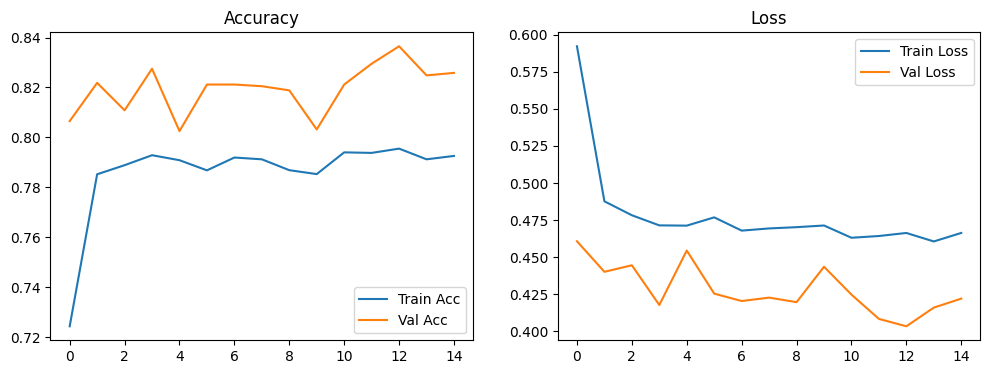

Evaluating on Test Set...
              precision    recall  f1-score   support

        fake       0.79      0.89      0.84      1505
        real       0.87      0.76      0.82      1500

    accuracy                           0.83      3005
   macro avg       0.83      0.83      0.83      3005
weighted avg       0.83      0.83      0.83      3005



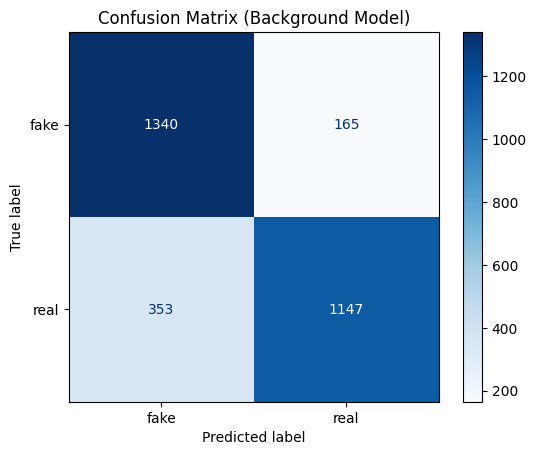

In [5]:
# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Evaluate on Test Set
print("Evaluating on Test Set...")
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Background Model)")
plt.show()